In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [ ]:
'''
A bunch of necessary imports
'''
import numpy as np
import seaborn as sbn
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow_docs.vis.embed as embed
from IPython import display as ipythondisplay
from PIL import Image
import uuid
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Q-Network Code

In [ ]:
'''
Bunch of Hyper parameters (Which you might have to tune later **wink wink**)
'''

BUFFER_SIZE = int(1e5)  # replay buffer size 
BATCH_SIZE = 64         # minibatch size 
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 
UPDATE_EVERY = 20       # how often to update the network (When Q target is present) 
NUM_HLAYERS = 2
HLAYER_SIZES = [128, 64]
TRUNC_LIM = 1

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcls = nn.ModuleList()
        for i in range(NUM_HLAYERS+1):
            if (i == 0):
                fc = nn.Linear(state_size, HLAYER_SIZES[0])
            elif (i == NUM_HLAYERS):
                fc = nn.Linear(HLAYER_SIZES[i-1], action_size)
            else:
                fc = nn.Linear(HLAYER_SIZES[i-1], HLAYER_SIZES[i])
            self.fcls.append(fc)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        for i in range(len(self.fcls)-1):
            fc = self.fcls[i]
            if i == 0:
                x = F.relu(fc(state))
            else:
                x = F.relu(fc(x))
        fc = self.fcls[len(self.fcls) - 1]
        return fc(x)

### Replay Buffer:

This is a 'deque' that helps us store experiences. Recall why we use such a technique.

In [ ]:
from collections import deque, namedtuple

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.rsg = np.random.RandomState(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        idxs = self.rsg.choice(len(self.memory), size=self.batch_size, replace=False)
        mem = self.memory
        states = torch.from_numpy(np.vstack([mem[i].state for i in idxs if mem[i] is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([mem[i].action for i in idxs if mem[i] is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([mem[i].reward for i in idxs if mem[i] is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([mem[i].next_state for i in idxs if mem[i] is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([mem[i].done for i in idxs if mem[i] is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### DQN Agent Code:

Truncation is done optionally with the hope that it improves stability.

In [ ]:
from scipy.special import softmax
class dqn_agent():
    def __init__(self, state_size, action_size, seed, atype='epsilon-greedy'):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.rsg = np.random.RandomState(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

        if atype == 'epsilon-greedy':
            self.act = self.eps_act 
        else:
            self.act = self.soft_act
    
    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)
        
        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''      
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def eps_act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        ''' Epsilon-greedy action selection (Already Present) '''
        if self.rsg.random() < eps:
            return self.rsg.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())

    def soft_act(self, state, beta=1.0):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Softmax action selection (Implemented) '''
        a_values = torch.squeeze(action_values).cpu().squeeze().data.numpy()
        return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()
        
        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-TRUNC_LIM, +TRUNC_LIM)
            
        self.optimizer.step()

### DQN algorithm

In [ ]:
def reward_shaping(state, next_state):
    sreward = 0
    if (next_state[0] >= 0.5):
        sreward += 400
    sreward += 400*((np.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (np.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
    return sreward

In [ ]:
''' Defining DQN Algorithm with epsilon annealing'''

def dqn(env, agent, env_score_req, use_eps = True, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.05, decay_factor=0.995, beta_start=1.5, beta_end=0.5):

    scores = []
    num_steps = []                 
    ''' list containing scores from each episode '''
    
    scores_window= deque(maxlen=100)  
    ''' last 100 scores for checking if the avg is more than -110 '''

    eps = eps_start
    beta = beta_start
        
    ''' initialize epsilon '''
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            if use_eps:
                action = agent.act(state, eps)
            else:
                action = agent.act(state, beta)
            next_state, reward, done, _ = env.step(action)
            shaped_reward = reward_shaping(state, next_state)
            agent.step(state, action, shaped_reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        num_steps.append(t)
        scores.append(score)
        scores_window.append(score) 
        ''' save most recent score '''           

        eps = max(eps_end, eps * decay_factor) 
        beta = max(beta_end, beta * decay_factor) 
        ''' decrease epsilon, beta '''

        print('\rEpisode {}\tAverage Score: {:.2f}\teps {}'.format(i_episode, np.mean(scores_window),eps) ,end="")     
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=env_score_req:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return [np.array(scores), np.array(num_steps), i_episode]

### Plotting and Rendering

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/CS6700/Assignments/Assignment2/DQN/MC/'

def gen_plots(fname, run_scores, run_steps, avg_num=10):

    run_count = len(run_scores)
    labels = [f'run {i+1}; epcount {len(run_scores[i])}' for i in range(run_count)]

    sc_fig, sc_ax = plt.subplots(figsize=(10,10))
    st_fig, st_ax = plt.subplots(figsize=(10,10))
    sc_ax.set_title(f'Running average of previous {avg_num} rewards;')
    sc_ax.set_xlabel('Episodes')
    sc_ax.set_ylabel('Reward')
    st_ax.set_title(f'Number of steps curve')
    st_ax.set_xlabel('Episodes')
    st_ax.set_ylabel('Steps')

    for idx in range(run_count):

        score_list = run_scores[idx]
        step_list = run_steps[idx]
        average_score_list = np.zeros_like(score_list)
        for i in range(0, len(score_list)):
            if i < avg_num:
                average_score_list[i] = np.mean(score_list[:(i+1)])
            else:
                average_score_list[i] = np.mean(score_list[(i-avg_num+1):(i+1)])
      
        sbn.lineplot(data=average_score_list, label=labels[idx], ax=sc_ax)
        sbn.lineplot(data=step_list, label=labels[idx], ax=st_ax)
      
    sc_fig.savefig(PATH+'/'+fname+'/sc_fig.png')
    st_fig.savefig(PATH+'/'+fname+'/st_fig.png')

def render_episode(env_name, agent, max_steps: int):
    env = gym.make(env_name) 
    env.reset()
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)

    images = [im]
    state = env.reset()
    for i in range(1, max_steps + 1):
        action = agent.act(state, 0.0)
        state, _, done, _ = env.step(action)

        # Render screen every 2 steps
        if i % 2 == 0:
            screen = env.render(mode='rgb_array')
            images.append(Image.fromarray(screen))
      
        if done:
            break
    
    return images

def save_gif(fname, env_name, torchagent, max_steps=800):
    display = Display(visible=0, size=(400, 300))
    display.start()
    # Save GIF image
    images = render_episode(env_name, torchagent, max_steps)
    image_file = PATH+'/'+fname+f'/render.gif'
    # loop=0: loop forever, duration=1: play each frame for 1ms
    images[0].save(image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

In [ ]:
# code for running the dqn for multiple to account for stochasticity. averaged performance is computed and returned
def dqn_exp_runner(env_name, num_runs, env_score_req, use_eps, start, end, decay_factor, n_episodes=800, max_t=1000):
    run_scores = []
    ep_counts = []
    run_steps = []
    agents = []
    env = gym.make(env_name)
    env.seed(42)
    if (use_eps):
        eps_start, eps_end = start, end
    else:
        beta_start, beta_end = start, end
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    for i in range(num_runs):
        begin_time = datetime.datetime.now()
        if use_eps:
            agent = dqn_agent(state_size=state_shape, action_size = action_shape, seed = 42, atype='epsilon-greedy')
            score_list, num_steps, ep_count = dqn(env, agent, env_score_req, use_eps = True, n_episodes=n_episodes, max_t=max_t, decay_factor=decay_factor, eps_start=eps_start, eps_end=eps_end)
        else:
            agent = dqn_agent(state_size=state_shape, action_size = action_shape, seed = 42, atype='softmax')
            score_list, num_steps, ep_count = dqn(env, agent, env_score_req, use_eps = False, n_episodes=n_episodes, max_t=max_t, decay_factor=decay_factor, beta_start=beta_start, beta_end=beta_end)
        time_taken = datetime.datetime.now() - begin_time
        run_scores.append(score_list)
        run_steps.append(num_steps)
        ep_counts.append(ep_count)
        agents.append(agent)
    ep_counts = np.array(ep_counts)
    # we use the median score getting the agent for render
    best_res = np.argsort(ep_counts)[len(ep_counts)//2]
    return run_scores, run_steps, np.mean(ep_counts), agents[best_res]

## MountainCar-v0

Saved to folder 0669668e-4518-4d19-b8d0-a7e1e128ab6d
Episode 100	Average Score: -192.27
Episode 200	Average Score: -134.17
Episode 300	Average Score: -127.83
Episode 345	Average Score: -124.78	eps 0.0005
Environment solved in 345 episodes!	Average Score: -124.78
Episode 100	Average Score: -196.30
Episode 200	Average Score: -139.03
Episode 222	Average Score: -124.90	eps 0.0005
Environment solved in 222 episodes!	Average Score: -124.90
Episode 100	Average Score: -191.39
Episode 200	Average Score: -139.09
Episode 300	Average Score: -137.49
Episode 400	Average Score: -136.38
Episode 500	Average Score: -130.76
Episode 579	Average Score: -124.96	eps 0.0005
Environment solved in 579 episodes!	Average Score: -124.96
Episode 100	Average Score: -190.79
Episode 200	Average Score: -135.41
Episode 234	Average Score: -124.81	eps 0.0005
Environment solved in 234 episodes!	Average Score: -124.81
Episode 100	Average Score: -192.12
Episode 196	Average Score: -124.96	eps 0.0005
Environment solved in 196 

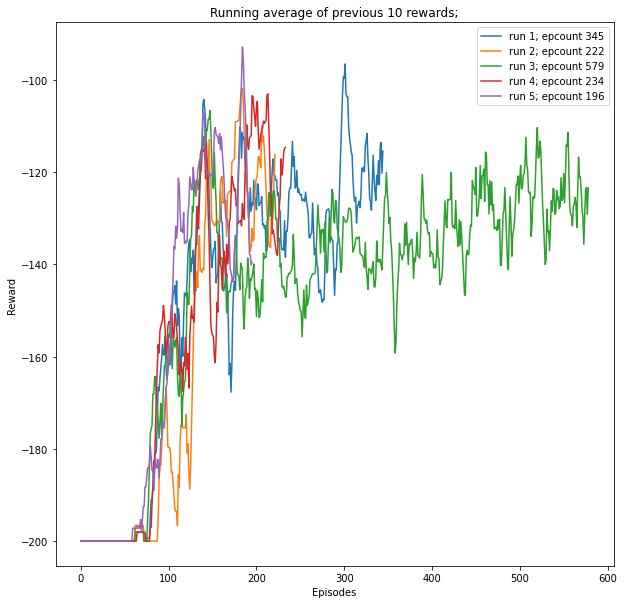

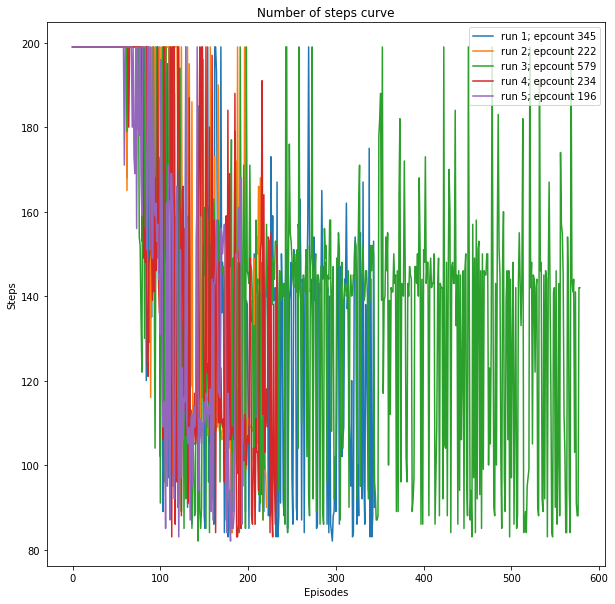

In [ ]:
#  Defaults
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder b9f56ac6-b84f-47e1-8c7d-ceeb75608345
Episode 100	Average Score: -192.83
Episode 200	Average Score: -146.86
Episode 300	Average Score: -127.63
Episode 388	Average Score: -124.29	eps 0.0005
Environment solved in 388 episodes!	Average Score: -124.29
Episode 100	Average Score: -189.12
Episode 200	Average Score: -127.92
Episode 214	Average Score: -124.82	eps 0.0005
Environment solved in 214 episodes!	Average Score: -124.82
Episode 100	Average Score: -187.23
Episode 200	Average Score: -126.30
Episode 204	Average Score: -124.88	eps 0.0005
Environment solved in 204 episodes!	Average Score: -124.88
Episode 100	Average Score: -193.04
Episode 200	Average Score: -156.97
Episode 300	Average Score: -141.92
Episode 400	Average Score: -132.90
Episode 500	Average Score: -139.36
Episode 600	Average Score: -131.51
Episode 700	Average Score: -131.11
Episode 800	Average Score: -139.29
Episode 100	Average Score: -193.86
Episode 200	Average Score: -141.97
Episode 300	Average Score: -139.16
Ep

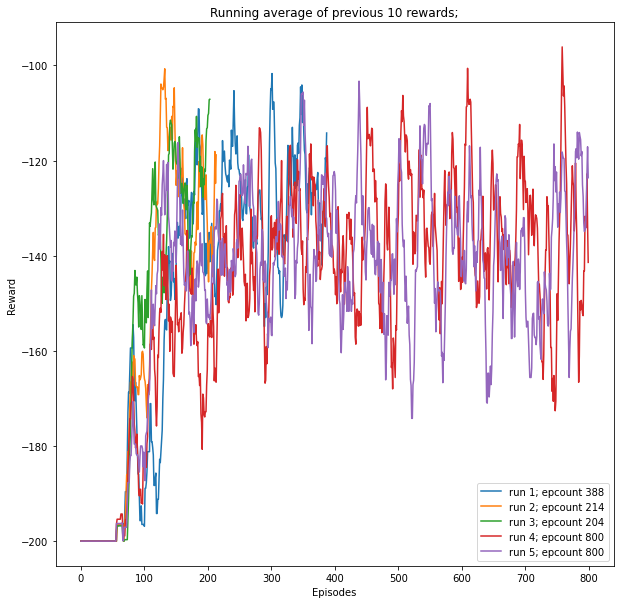

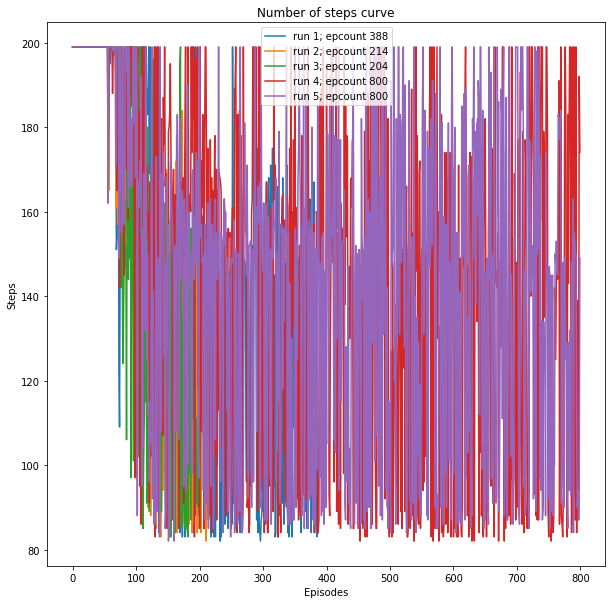

In [ ]:
#  Defaults, gamma=0.97
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.97
LR = 5e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder 4d441f6f-9aeb-45ef-a15b-6860aee3f6ee
Episode 100	Average Score: -191.22
Episode 200	Average Score: -129.91
Episode 214	Average Score: -124.90	eps 0.0005
Environment solved in 214 episodes!	Average Score: -124.90
Episode 100	Average Score: -190.80
Episode 200	Average Score: -135.26
Episode 224	Average Score: -124.67	eps 0.0005
Environment solved in 224 episodes!	Average Score: -124.67
Episode 100	Average Score: -186.87
Episode 200	Average Score: -126.89
Episode 208	Average Score: -124.86	eps 0.0005
Environment solved in 208 episodes!	Average Score: -124.86
Episode 100	Average Score: -186.80
Episode 200	Average Score: -133.30
Episode 233	Average Score: -124.89	eps 0.0005
Environment solved in 233 episodes!	Average Score: -124.89
Episode 100	Average Score: -191.35
Episode 200	Average Score: -133.03
Episode 231	Average Score: -124.57	eps 0.0005
Environment solved in 231 episodes!	Average Score: -124.57
Performance 222.0


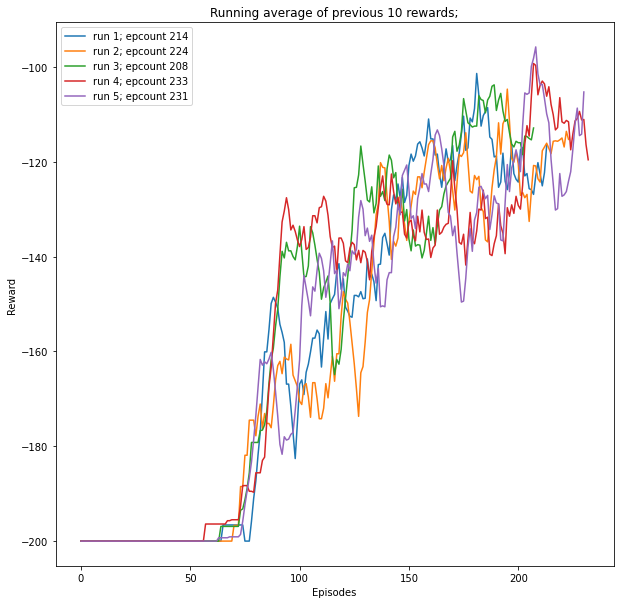

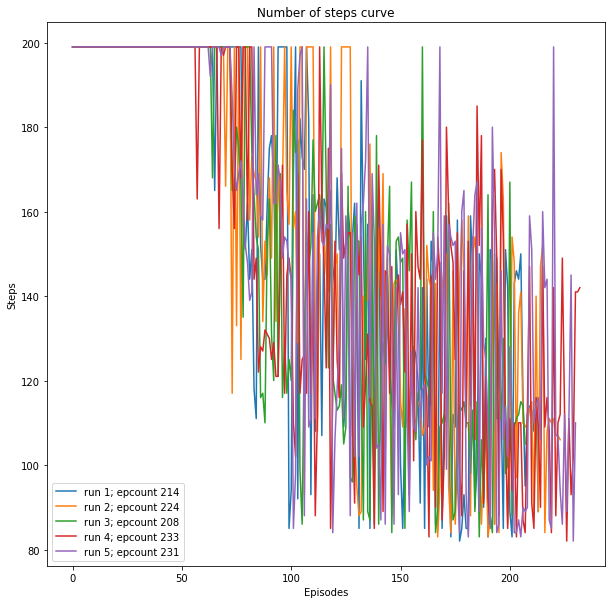

In [ ]:
# From defaults : Learning rate changed to 9e-4
BUFFER_SIZE = int(10000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder 70b7f373-bcfe-4412-af28-ec5a0b0a3c41
Episode 100	Average Score: -192.85
Episode 200	Average Score: -130.04
Episode 237	Average Score: -124.69	eps 0.0005
Environment solved in 237 episodes!	Average Score: -124.69
Episode 100	Average Score: -190.19
Episode 200	Average Score: -130.76
Episode 300	Average Score: -131.59
Episode 378	Average Score: -124.93	eps 0.0005
Environment solved in 378 episodes!	Average Score: -124.93
Episode 100	Average Score: -189.85
Episode 200	Average Score: -137.01
Episode 300	Average Score: -127.86
Episode 400	Average Score: -131.08
Episode 464	Average Score: -124.78	eps 0.0005
Environment solved in 464 episodes!	Average Score: -124.78
Episode 100	Average Score: -186.92
Episode 200	Average Score: -131.79
Episode 235	Average Score: -124.85	eps 0.0005
Environment solved in 235 episodes!	Average Score: -124.85
Episode 100	Average Score: -189.65
Episode 200	Average Score: -135.66
Episode 277	Average Score: -124.96	eps 0.0005
Environment solved in 277 

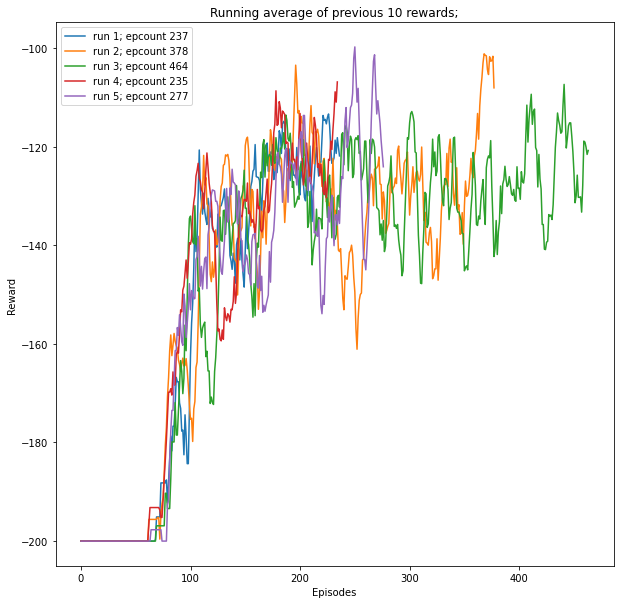

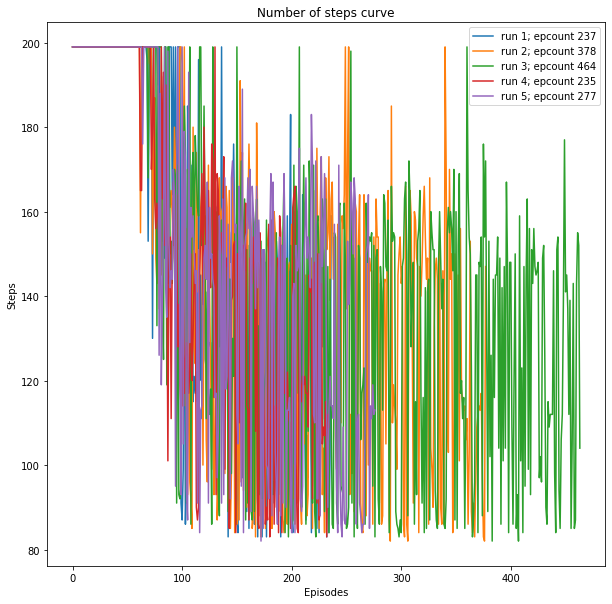

In [ ]:
# From defaults : Learning rate changed to 9e-4,Buffer size=40000
BUFFER_SIZE = int(40000)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder a4cc0da5-b2b1-49b1-a61f-f0afb6309292
Episode 100	Average Score: -191.35
Episode 200	Average Score: -126.25
Episode 203	Average Score: -124.93	eps 0.0005
Environment solved in 203 episodes!	Average Score: -124.93
Episode 100	Average Score: -185.83
Episode 200	Average Score: -128.55
Episode 221	Average Score: -125.00	eps 0.0005
Environment solved in 221 episodes!	Average Score: -125.00
Episode 100	Average Score: -197.58
Episode 200	Average Score: -131.85
Episode 230	Average Score: -124.81	eps 0.0005
Environment solved in 230 episodes!	Average Score: -124.81
Episode 100	Average Score: -191.72
Episode 200	Average Score: -126.61
Episode 206	Average Score: -124.68	eps 0.0005
Environment solved in 206 episodes!	Average Score: -124.68
Episode 100	Average Score: -187.88
Episode 190	Average Score: -124.23	eps 0.0005854435220485529
Environment solved in 190 episodes!	Average Score: -124.23
Performance 210.0


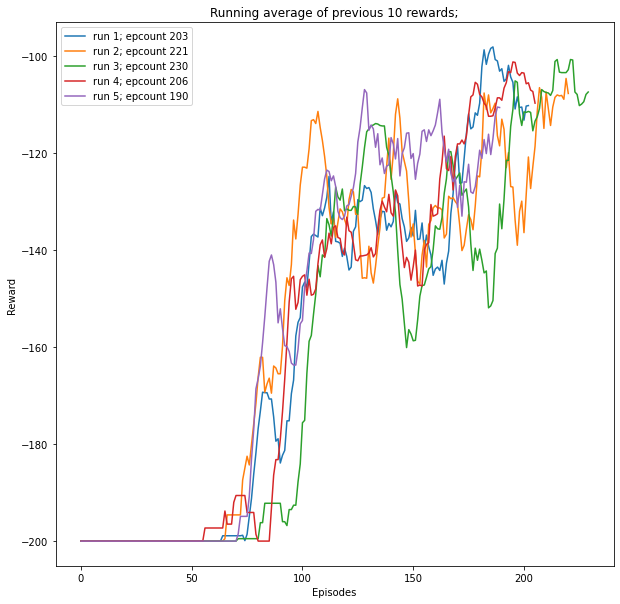

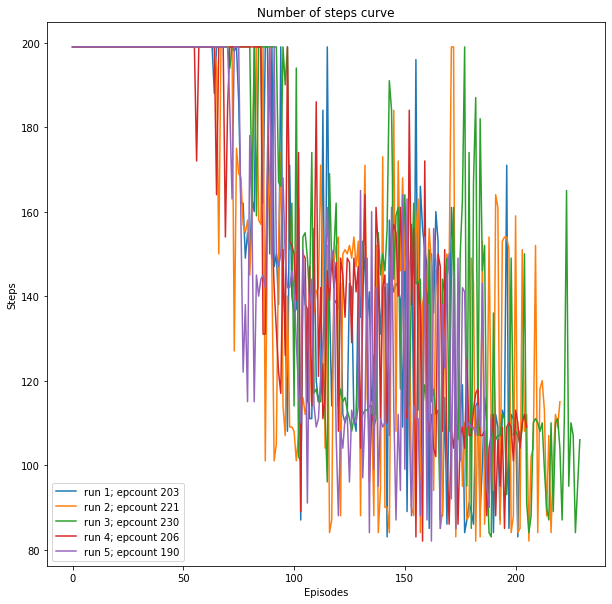

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=128
BUFFER_SIZE = int(10000)
BATCH_SIZE = 128
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder 03a772cb-8d43-4128-82b9-18b78bc3fcf5
Episode 100	Average Score: -191.36
Episode 181	Average Score: -124.82	eps 0.0009289076879966705
Environment solved in 181 episodes!	Average Score: -124.82
Episode 100	Average Score: -184.75
Episode 196	Average Score: -124.94	eps 0.0005
Environment solved in 196 episodes!	Average Score: -124.94
Episode 100	Average Score: -184.31
Episode 189	Average Score: -124.50	eps 0.0006162563389984768
Environment solved in 189 episodes!	Average Score: -124.50
Episode 100	Average Score: -192.02
Episode 191	Average Score: -124.75	eps 0.0005561713459461252
Environment solved in 191 episodes!	Average Score: -124.75
Episode 100	Average Score: -186.55
Episode 200	Average Score: -127.95
Episode 209	Average Score: -124.73	eps 0.0005
Environment solved in 209 episodes!	Average Score: -124.73
Performance 193.2


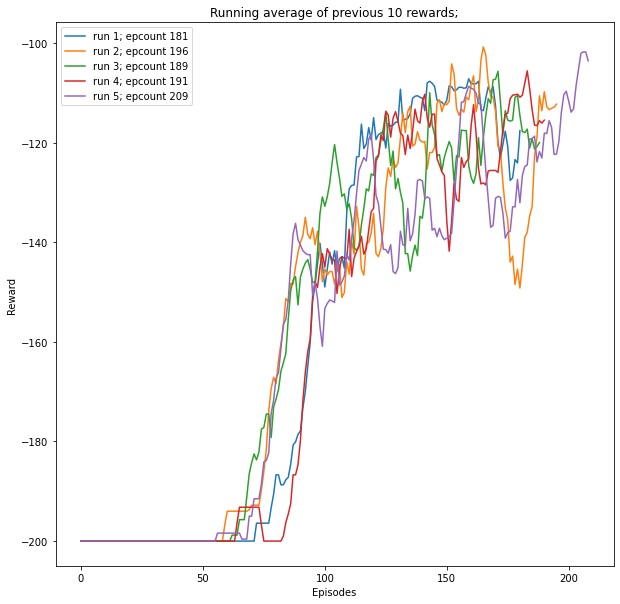

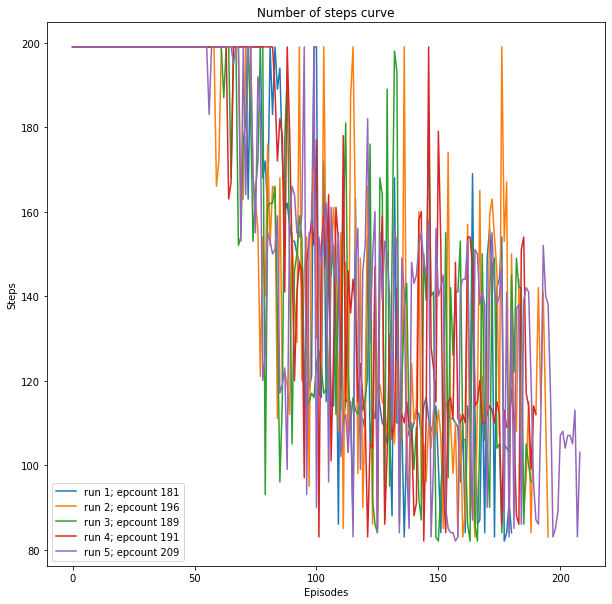

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder e84ca841-d473-4609-b3ff-4d1a23e8ff5f
Episode 100	Average Score: -192.37
Episode 200	Average Score: -125.13
Episode 201	Average Score: -124.11	eps 0.0005
Environment solved in 201 episodes!	Average Score: -124.11
Episode 100	Average Score: -191.27
Episode 200	Average Score: -124.58

Environment solved in 200 episodes!	Average Score: -124.58
Episode 100	Average Score: -190.38
Episode 182	Average Score: -124.87	eps 0.0008824623035968369
Environment solved in 182 episodes!	Average Score: -124.87
Episode 100	Average Score: -196.75
Episode 200	Average Score: -139.39
Episode 231	Average Score: -124.24	eps 0.0005
Environment solved in 231 episodes!	Average Score: -124.24
Episode 100	Average Score: -196.57
Episode 200	Average Score: -131.78
Episode 221	Average Score: -124.97	eps 0.0005
Environment solved in 221 episodes!	Average Score: -124.97
Performance 207.0


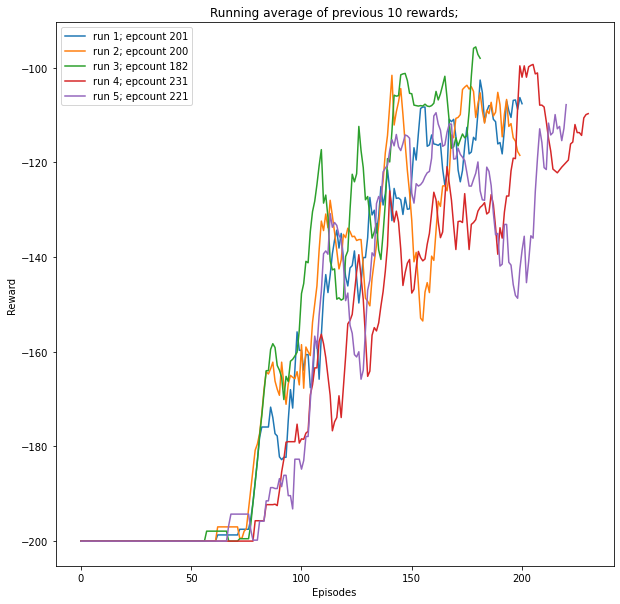

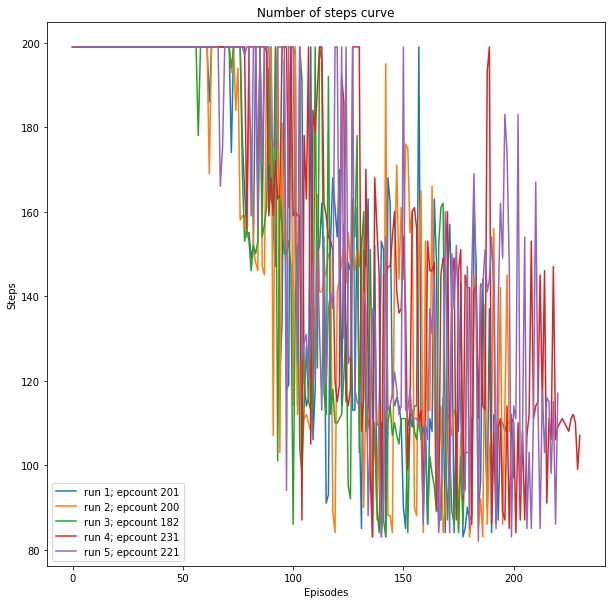

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,update every=50
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 50
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder bbc2aebf-d1ca-4735-87e4-e8c7634d54be
Episode 100	Average Score: -192.53
Episode 200	Average Score: -148.38
Episode 287	Average Score: -124.64	eps 0.0005
Environment solved in 287 episodes!	Average Score: -124.64
Episode 100	Average Score: -197.49
Episode 200	Average Score: -131.80
Episode 300	Average Score: -139.56
Episode 353	Average Score: -124.48	eps 0.0005
Environment solved in 353 episodes!	Average Score: -124.48
Episode 100	Average Score: -195.63
Episode 200	Average Score: -137.91
Episode 262	Average Score: -124.43	eps 0.0005
Environment solved in 262 episodes!	Average Score: -124.43
Episode 100	Average Score: -196.47
Episode 200	Average Score: -132.07
Episode 213	Average Score: -124.74	eps 0.0005
Environment solved in 213 episodes!	Average Score: -124.74
Episode 100	Average Score: -192.01
Episode 200	Average Score: -140.26
Episode 296	Average Score: -124.87	eps 0.0005
Environment solved in 296 episodes!	Average Score: -124.87
Performance 282.2


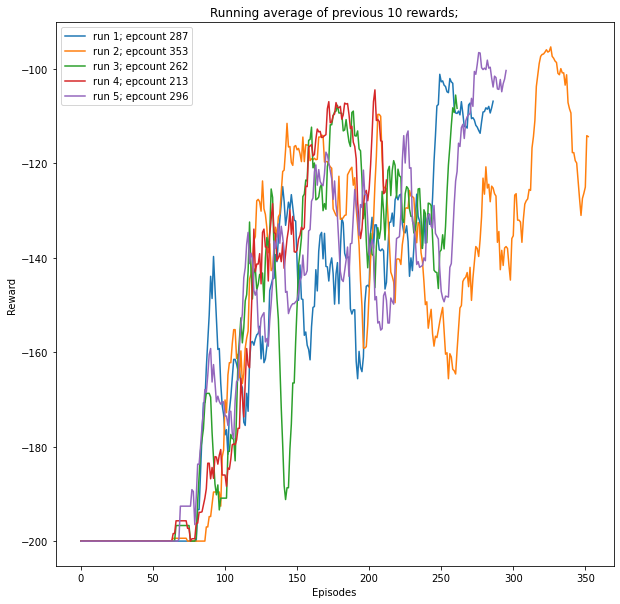

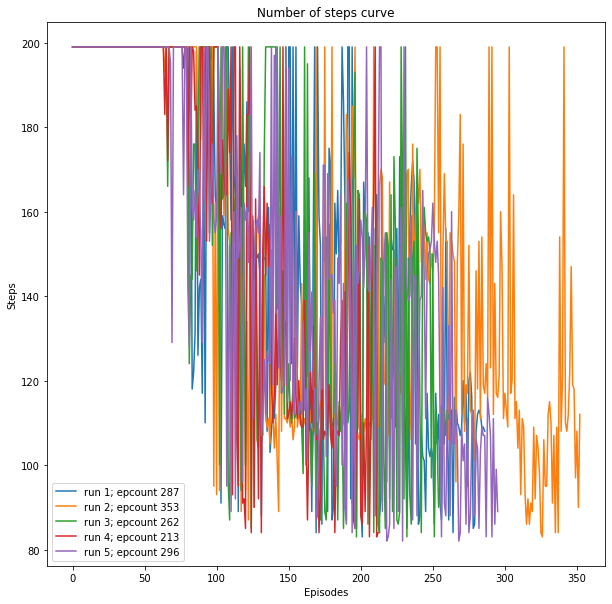

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,update every=100
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 100
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.95)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder 1fa6045d-759d-4a77-85fb-8e962cc23193
Episode 100	Average Score: -156.77
Episode 146	Average Score: -124.86	eps 0.0005
Environment solved in 146 episodes!	Average Score: -124.86
Episode 100	Average Score: -145.74
Episode 139	Average Score: -124.90	eps 0.0005
Environment solved in 139 episodes!	Average Score: -124.90
Episode 100	Average Score: -151.79
Episode 151	Average Score: -124.11	eps 0.0005
Environment solved in 151 episodes!	Average Score: -124.11
Episode 100	Average Score: -162.71
Episode 200	Average Score: -125.58
Episode 202	Average Score: -124.87	eps 0.0005
Environment solved in 202 episodes!	Average Score: -124.87
Episode 100	Average Score: -151.63
Episode 142	Average Score: -124.87	eps 0.0005
Environment solved in 142 episodes!	Average Score: -124.87
Performance 156.0


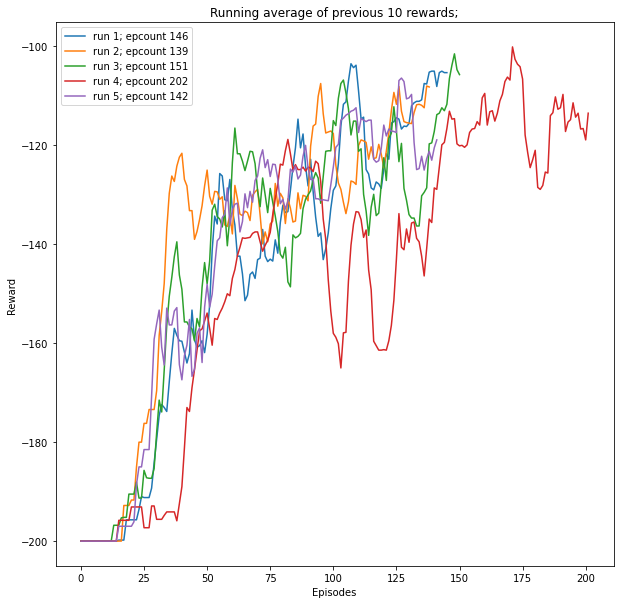

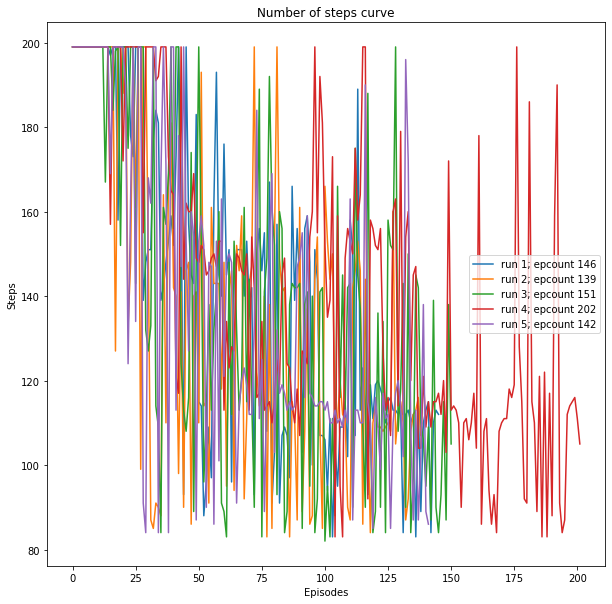

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,decay factor=0.8
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.0005, decay_factor=0.8)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder ca92f8da-5c7f-429d-8206-961487c01341
Episode 100	Average Score: -155.78
Episode 147	Average Score: -124.84	eps 1e-05
Environment solved in 147 episodes!	Average Score: -124.84
Episode 100	Average Score: -151.87
Episode 184	Average Score: -124.57	eps 1e-05
Environment solved in 184 episodes!	Average Score: -124.57
Episode 100	Average Score: -144.90
Episode 123	Average Score: -124.64	eps 1e-05
Environment solved in 123 episodes!	Average Score: -124.64
Episode 100	Average Score: -153.13
Episode 163	Average Score: -124.47	eps 1e-05
Environment solved in 163 episodes!	Average Score: -124.47
Episode 100	Average Score: -159.66
Episode 168	Average Score: -124.91	eps 1e-05
Environment solved in 168 episodes!	Average Score: -124.91
Performance 157.0


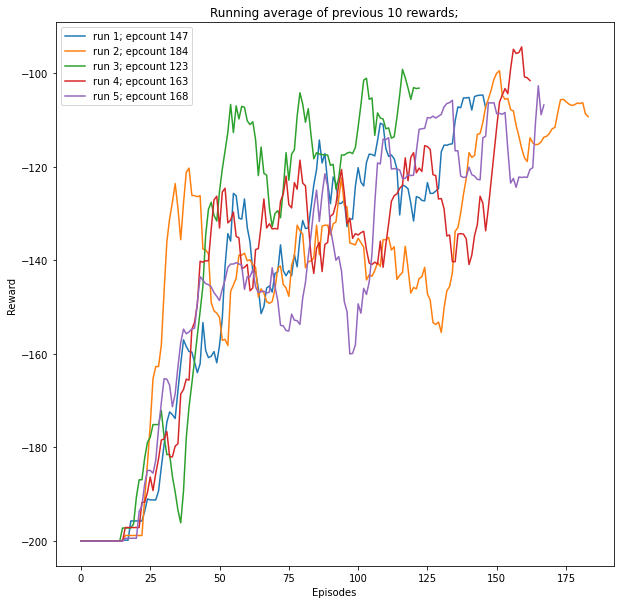

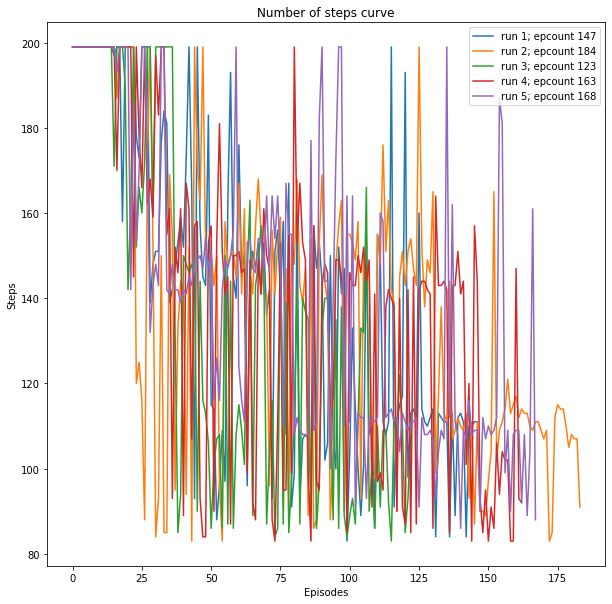

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,decay factor=0.8,epsilon_end=0.00001
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=True, start=10, end=0.00001, decay_factor=0.8)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder bca7894b-2d38-4254-8920-e844510acfd0
Episode 100	Average Score: -187.21
Episode 200	Average Score: -133.73
Episode 227	Average Score: -124.96	eps 0.05
Environment solved in 227 episodes!	Average Score: -124.96
Episode 100	Average Score: -163.97
Episode 149	Average Score: -124.44	eps 0.05
Environment solved in 149 episodes!	Average Score: -124.44
Episode 100	Average Score: -158.86
Episode 172	Average Score: -124.81	eps 0.05
Environment solved in 172 episodes!	Average Score: -124.81
Episode 100	Average Score: -156.14
Episode 146	Average Score: -124.61	eps 0.05
Environment solved in 146 episodes!	Average Score: -124.61
Episode 100	Average Score: -174.40
Episode 200	Average Score: -132.04
Episode 244	Average Score: -124.42	eps 0.05
Environment solved in 244 episodes!	Average Score: -124.42
Performance 187.6


<ipython-input-6-4c3fc3a85a06>:66: RuntimeWarning: divide by zero encountered in true_divide
  return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


ValueError: ignored

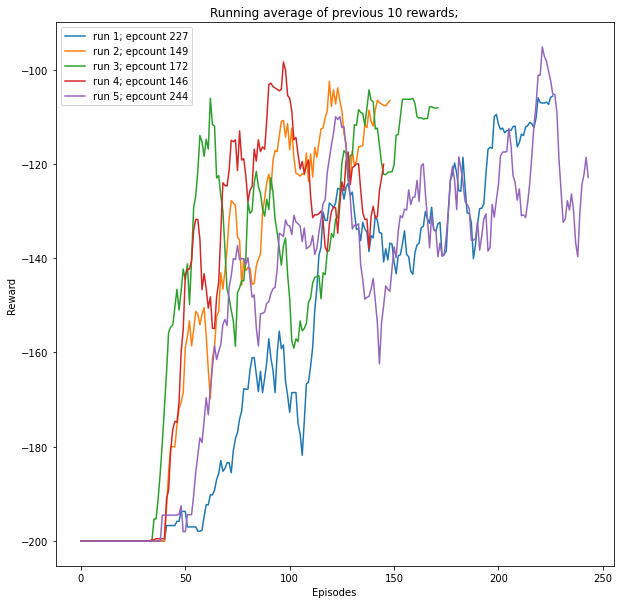

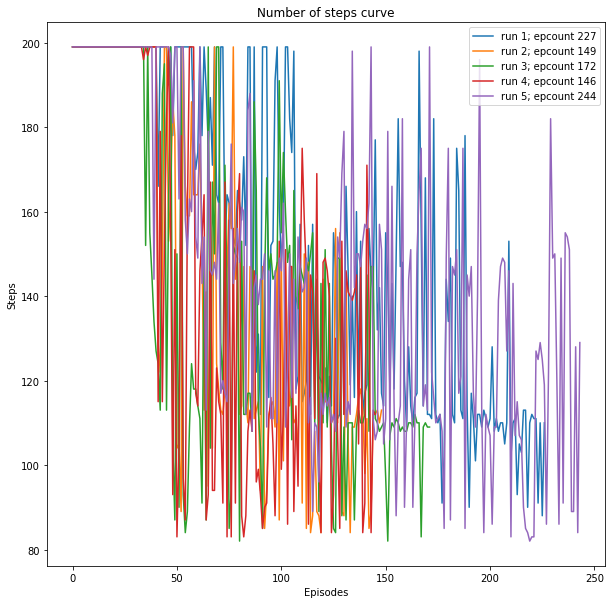

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,decay factor=0.8,epsilon_end=0.00001,eps_start=40,softmax
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=False, start=40, end=0.00001, decay_factor=0.8)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)

Saved to folder 762cfa7c-21b7-4969-a369-6c6605862464
Episode 100	Average Score: -152.92
Episode 155	Average Score: -124.65	eps 0.05
Environment solved in 155 episodes!	Average Score: -124.65
Episode 100	Average Score: -148.94
Episode 142	Average Score: -124.71	eps 0.05
Environment solved in 142 episodes!	Average Score: -124.71
Episode 100	Average Score: -150.10
Episode 145	Average Score: -124.34	eps 0.05
Environment solved in 145 episodes!	Average Score: -124.34
Episode 100	Average Score: -150.29
Episode 131	Average Score: -124.85	eps 0.05
Environment solved in 131 episodes!	Average Score: -124.85
Episode 100	Average Score: -147.13
Episode 157	Average Score: -124.77	eps 0.05
Environment solved in 157 episodes!	Average Score: -124.77
Performance 146.0


<ipython-input-6-4c3fc3a85a06>:66: RuntimeWarning: divide by zero encountered in true_divide
  return self.rsg.choice(np.arange(self.action_size), size=1, p=softmax(a_values/beta))[0]
/usr/local/lib/python3.9/dist-packages/scipy/special/_logsumexp.py:224: RuntimeWarning: invalid value encountered in subtract
  exp_x_shifted = np.exp(x - x_max)


ValueError: ignored

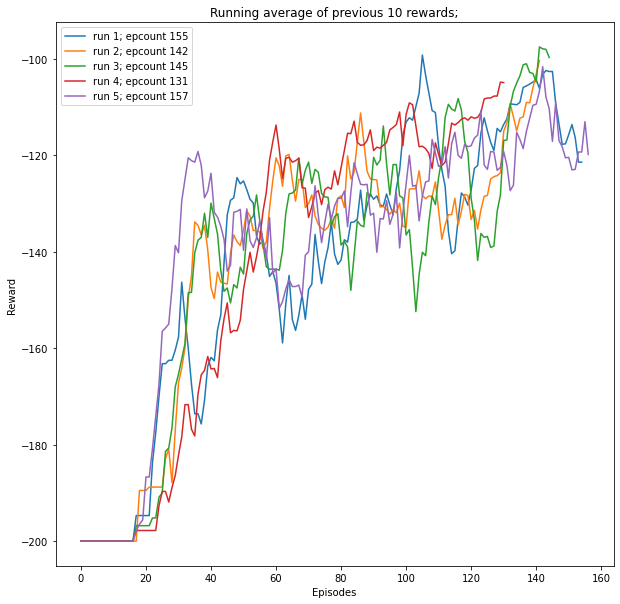

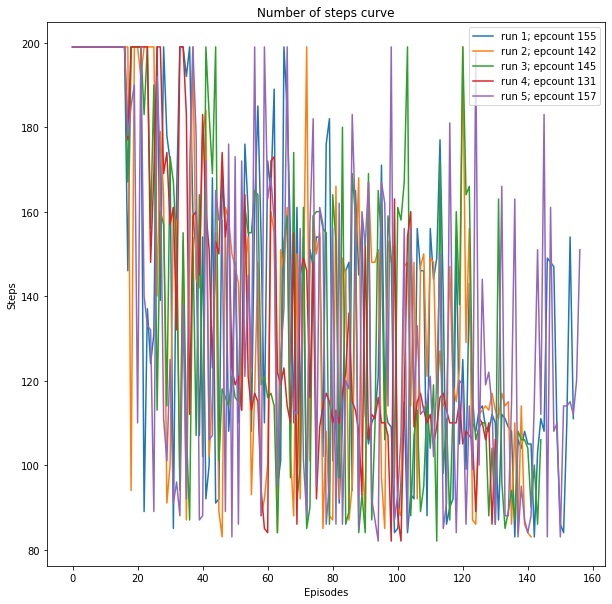

In [ ]:
# From defaults : Learning rate changed to 9e-4,batch size=256,decay factor=0.6,epsilon_end=0.00001,eps start=40,softmax
BUFFER_SIZE = int(10000)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 9e-4
UPDATE_EVERY = 20
NUM_HLAYERS = 3
HLAYER_SIZES = [64,64, 128]
TRUNC_LIM = 1e32


fname = str(uuid.uuid4())
print(f'Saved to folder {fname}')
os.mkdir(PATH+'/'+fname)
run_scores, run_steps, ep_count_average, median_agent = dqn_exp_runner('MountainCar-v0', num_runs=5, env_score_req=-125, 
                                                                     use_eps=False, start=40, end=0.00001, decay_factor=0.6)
print(f'Performance {ep_count_average}')
gen_plots(fname, run_scores, run_steps)
save_gif(fname, 'MountainCar-v0', median_agent,max_steps=800)